- Basic seq2seq without attention by dictionary word2vec
- Seq2seq with attention by dictionary word2vec
- Seq2seq with attention by pre-trained wiki word embeddings

And the dataset I used in this project can be download here:
https://www.kaggle.com/snap/amazon-fine-food-reviews/download

Also you can open this .ipynb in Colab:
https://colab.research.google.com/drive/17MPQCgVwE2QTAVMPwQMprle6IcCl5jr2#scrollTo=1xvhWFX77RB5

## Basic seq2seq by dictionary word2vec

In [0]:
import os
import sys
import math
from collections import Counter
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import pickle
import random
import sys

import nltk
nltk.download('punkt')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
cuda


In [0]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [0]:
DATA_PATH = 'drive/My Drive/'
reviews = pd.read_csv(f'{DATA_PATH}Reviews.csv', usecols=['Summary', 'Text'], engine='python', encoding='utf-8', error_bad_lines=False)

# drop rows with no Summary
reviews.dropna(inplace=True)

# drop duplicated 
reviews.drop_duplicates(['Text'], keep='first', inplace=True)
print('total reviews', reviews.shape[0])
reviews.head(5)

total reviews 393576


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


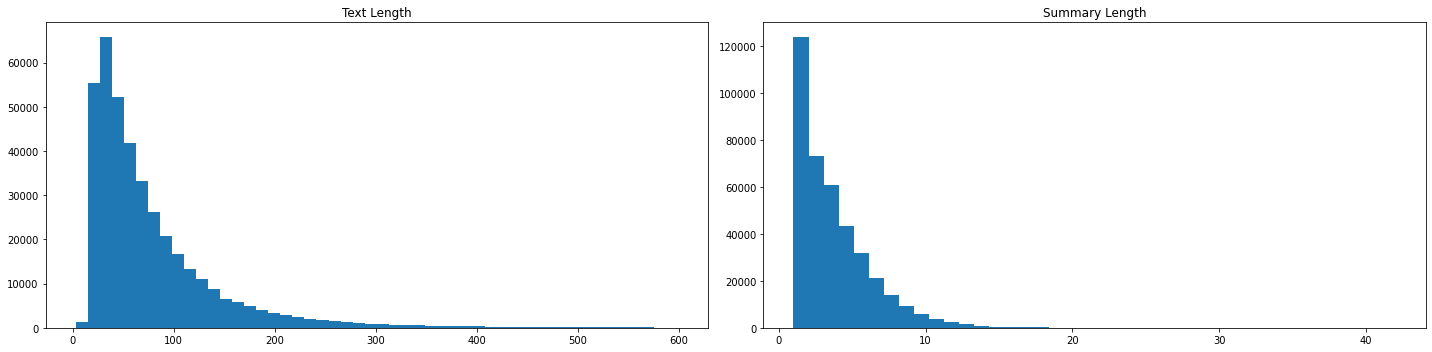

In [0]:
reviews['Summary_len'] = reviews.Summary.apply(lambda x: len(x.split()))
reviews['Text_len'] = reviews.Text.apply(lambda x: len(x.split()))  

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(reviews.Text_len[reviews['Text_len'] < 600], bins=50)
plt.title('Text Length')

plt.subplot(1, 2, 2)
plt.hist(reviews['Summary_len'], bins=40)
plt.title('Summary Length')
plt.tight_layout()

In [0]:
reviews.head()

,Summary,Text,Summary_len,Text_len
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,4,48
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,3,31
2,"""Delight"" says it all",This is a confection that has been around a fe...,4,94
3,Cough Medicine,If you are looking for the secret ingredient i...,2,41
4,Great taffy,Great taffy at a great price. There was a wid...,2,27


In [0]:
print('Text length 90 percentile:', np.percentile(reviews.Text_len, 90))
print('Summary length 99 percentile:', np.percentile(reviews.Summary_len, 99))

Text length 90 percentile: 159.0
Summary length 99 percentile: 12.0


In [0]:
# drop short reviews < 10
reviews = reviews[(reviews['Text_len'] > 50) & (reviews['Text_len'] < 200)].reset_index(drop=True)

print('total reviews', reviews.shape[0])

total reviews 195348


In [0]:
train_df, test_df = train_test_split(reviews, test_size=0.1, random_state=100)

In [0]:
train_df.head(3)

,Summary,Text,Summary_len,Text_len
60674,Syrup,Have searched for this product for several yea...,1,85
59110,My dog LOVES these bones and so do I....,These bones really freshen the breath and clea...,9,85
11482,"good taste, a little too salty","These chips are unusual and they do ""grow"" on ...",6,52


In [0]:
def load_data(df):
    text = []
    summ = []
    num_examples = 0

    for line in df.Text.values:
          line = line.strip().split("\t")
          text.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])

    for line in df.Summary.values:
          line = line.strip().split("\t")
          summ.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])
    
    return text, summ

In [0]:
train_text, train_summ = load_data(train_df)
dev_text, dev_summ = load_data(test_df)

In [0]:
print(train_text[0])
print(train_summ[0])
print(dev_text[0])
print(dev_summ[0])

['BOS', 'have', 'searched', 'for', 'this', 'product', 'for', 'several', 'years', 'since', 'we', 'moved', 'to', 'kentucky', 'from', 'vermont', '.', 'we', 'have', 'always', 'picked', 'up', 'several', 'bottles', 'when', 'we', 'go', 'home', 'to', 'visit', 'but', 'since', 'we', 'flew', 'the', 'last', 'couple', 'of', 'times', ',', 'we', 'were', 'unable', 'to', 'bring', 'it', 'back', 'with', 'us', '.', 'i', 'found', 'this', 'online', 'at', 'amazon.com', 'at', 'a', 'very', 'reasonable', 'price', 'and', 'shipping', 'was', 'free', 'because', 'i', 'ordered', 'something', 'else', 'as', 'well', '.', 'although', 'we', 'are', 'from', 'vermont', ',', 'my', 'whole', 'family', 'prefers', 'the', 'vermont', 'maid', 'syrup', 'to', 'the', 'genuine', 'article', '.', 'EOS']
['BOS', 'syrup', 'EOS']
['BOS', 'we', 'are', 'a', 'family', 'who', 'love', 'our', 'bottled', 'sodas', 'so', 'i', 'must', 'say', 'i', "'ve", 'been', 'disappointed', 'with', 'the', 'selections', 'we', "'ve", 'had', 'lately', '.', 'i', 'know'

In [0]:
UNK_IDX = 0
PAD_IDX = 1

def build_dict(sentences, max_words=50000):
    word_count = Counter()
    for sentence in sentences:
        for s in sentence:
            word_count[s] += 1
    ls = word_count.most_common(max_words)
    total_words = len(ls) + 2
    word_dict = {w[0]: index+2 for index, w in enumerate(ls)}
    word_dict["UNK"] = UNK_IDX
    word_dict["PAD"] = PAD_IDX
    return word_dict, total_words

text_dict, text_total_words = build_dict(train_text)
summ_dict, summ_total_words = build_dict(train_summ)
inv_text_dict = {v: k for k, v in text_dict.items()}
inv_summ_dict = {v: k for k, v in summ_dict.items()}

In [0]:
print(text_total_words, summ_total_words)

50002 27782


In [0]:
def embedding(text_sentences, summ_sentences, text_dict, summ_dict, sort_by_len=True):
    '''
    Enmbedding the sentence to vector sequences.  
    '''
    length = len(text_sentences)
    out_text_sentences = [[text_dict.get(w, 0) for w in sent] for sent in text_sentences]
    out_summ_sentences = [[summ_dict.get(w, 0) for w in sent] for sent in summ_sentences]

    # sort sentences by english lengths
    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))
       
    if sort_by_len:
        sorted_index = len_argsort(out_text_sentences)
        out_text_sentences = [out_text_sentences[i] for i in sorted_index]
        out_summ_sentences = [out_summ_sentences[i] for i in sorted_index]
        
    return out_text_sentences, out_summ_sentences

train_text, train_summ = embedding(train_text, train_summ, text_dict, summ_dict)
dev_text, dev_summ = embedding(dev_text, dev_summ, text_dict, summ_dict)

In [0]:
print(train_text[0])
print(train_summ[0])
print(dev_text[0])
print(dev_summ[0])

[19, 22, 390, 840, 18, 12, 0, 315, 150, 407, 338, 7, 2830, 443, 249, 10, 14802, 3650, 688, 66, 2, 119, 3780, 35, 172, 43, 8, 29, 2, 4, 2138, 528, 338, 361, 4, 252, 100, 8, 2, 22210, 57, 1073, 50, 6, 823, 483, 66, 2, 4, 60, 13918, 167, 20]
[2, 6, 89, 3]
[19, 8371, 255, 304, 6, 13761, 11, 3, 117, 4294, 824, 85, 11, 4, 89, 8, 17, 22, 135, 66, 6, 1723, 7, 2869, 1464, 6, 56, 134, 75, 66, 148, 46, 37, 128, 1723, 35, 7, 342, 1125, 333, 8, 450, 57, 603, 87, 18, 401, 57, 969, 6, 182, 255, 20]
[2, 9024, 7, 14, 3]


In [0]:
def get_minibatches(n, minibatch_size, shuffle=True):
    idx_list = np.arange(0, n, minibatch_size)
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    for idx in idx_list:
        minibatches.append(np.arange(idx, min(idx + minibatch_size, n)))
    return minibatches

def prepare_data(seqs):
    lengths = [len(seq) for seq in seqs]
    n_samples = len(seqs)
    max_len = np.max(lengths)

    x = np.zeros((n_samples, max_len)).astype('int32')
    x_lengths = np.array(lengths).astype("int32")
    for idx, seq in enumerate(seqs):
        x[idx, :lengths[idx]] = seq
    return x, x_lengths #x_mask

def gen_examples(text_sentences, summ_sentences, batch_size):
    minibatches = get_minibatches(len(text_sentences), batch_size)
    all_ex = []
    for minibatch in minibatches:
        mb_text_sentences = [text_sentences[t] for t in minibatch]
        mb_summ_sentences = [summ_sentences[t] for t in minibatch]
        mb_x, mb_x_len = prepare_data(mb_text_sentences)
        mb_y, mb_y_len = prepare_data(mb_summ_sentences)
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
    return all_ex

batch_size = 64
train_data = gen_examples(train_text, train_summ, batch_size)
random.shuffle(train_data)
dev_data = gen_examples(dev_text, dev_summ, batch_size)

In [0]:
print(len(train_data))
print(len(train_data[0]))
print(len(train_data[0][0]))
print(len(train_data[0][0][1]))

print(train_data[0][0][0])

2748
4
64
110
[   19     4    29  1506    58     4   131    38    24     4    63     7
   484 13270    36     4  1132     4    60  2249     8     2    25   180
    32  1018     3   113   122    10    52     5    24   210    17   708
    21    85    11     7   444   151   255  1928   107    47    25    26
  1102     2    21   246   317   929   151    11   152    86 10251   113
     5   202    70   929   312    10    96     4   758   565   295   764
     2     3   255    11   533  2632   356     5     6     3   848    31
  2171    17   212   409     6   247   249  1780  6306     2    30   826
   224     5     6    30    26 10251    59     2   297   167    12    55
     2    20]


In [0]:
class PlainEncoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        super(PlainEncoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()
        
        return out, hid[[-1]]

class PlainDecoder(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.2):
        super(PlainDecoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, y, y_lengths, hid):
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()]

        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, output_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        # print(output_seq.shape)
        hid = hid[:, original_idx.long()].contiguous()
        output = F.log_softmax(self.out(output_seq), -1)
        
        return output, hid
    
class PlainSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(PlainSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        output, hid = self.decoder(y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        return output, None
    
    def predict(self, x, x_lengths, y, max_length=12):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid = self.decoder(y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            
        return torch.cat(preds, 1), None

In [0]:
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):
        input = input.contiguous().view(-1, input.size(2))
        target = target.contiguous().view(-1, 1)
        mask = mask.contiguous().view(-1, 1)
        output = -input.gather(1, target) * mask
        output = torch.sum(output) / torch.sum(mask)

        return output

In [0]:
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():
        for it, (mb_x, mb_x_lengths, mb_y, mb_y_lengths) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).long().to(device)
            mb_x_lengths = torch.from_numpy(mb_x_lengths).long().to(device)
            mb_input = torch.from_numpy(mb_y[:,:-1]).long().to(device)
            mb_out = torch.from_numpy(mb_y[:, 1:]).long().to(device)
            mb_y_lengths = torch.from_numpy(mb_y_lengths-1).long().to(device)
            mb_y_lengths[mb_y_lengths <= 0] = 1

            mb_pred, attn = model(mb_x, mb_x_lengths, mb_input, mb_y_lengths)

            mb_out_mask = torch.arange(mb_y_lengths.max().item(), device=device)[None, :] < mb_y_lengths[:, None]
            mb_out_mask = mb_out_mask.float()
            loss = crit(mb_pred, mb_out, mb_out_mask)

            num_words = torch.sum(mb_y_lengths).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words

    print("evaluation loss", total_loss/total_num_words)

In [0]:
def train(model, data, num_epochs):
    ls = []
    for epoch in range(num_epochs):
        total_num_words = total_loss = 0.
        model.train()
        for it, (mb_x, mb_x_lengths, mb_y, mb_y_lengths) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).long().to(device)
            mb_x_lengths = torch.from_numpy(mb_x_lengths).long().to(device)
            mb_input = torch.from_numpy(mb_y[:,:-1]).long().to(device)
            mb_out = torch.from_numpy(mb_y[:, 1:]).long().to(device)
            mb_y_lengths = torch.from_numpy(mb_y_lengths-1).long().to(device)
            mb_y_lengths[mb_y_lengths <= 0] = 1

            mb_pred, attn = model(mb_x, mb_x_lengths, mb_input, mb_y_lengths)

            mb_out_mask = torch.arange(mb_y_lengths.max().item(), device=device)[None, :] < mb_y_lengths[:, None]
            mb_out_mask = mb_out_mask.float()
            loss = crit(mb_pred, mb_out, mb_out_mask)

            num_words = torch.sum(mb_y_lengths).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            optimizer.step()

            if it % 100 == 0:
                print("epoch", epoch, "iteration", it, "loss", loss.item())
        print("epoch", epoch, "training loss", total_loss/total_num_words)
        if epoch % 5 == 0:
            print("evaluating on dev...")
            evaluate(model, dev_data)

        ls.append(total_loss/total_num_words)

    return ls    

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout=0.1

text_vocab_size = len(text_dict)
summ_vocab_size = len(summ_dict)
embed_size = hidden_size = 100

encoder = PlainEncoder(vocab_size=text_vocab_size, 
                  hidden_size=hidden_size,
                dropout=dropout)
decoder = PlainDecoder(vocab_size=summ_vocab_size, 
                  hidden_size=hidden_size,
                      dropout=dropout)

model_no_att = PlainSeq2Seq(encoder, decoder)
model_no_att = model_no_att.to(device)

crit = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model_no_att.parameters())

In [0]:
loss = train(model_no_att, train_data, 2)

In [0]:
def plot_loss(loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='train_loss')
    plt.legend()
    plt.title('Training Results')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

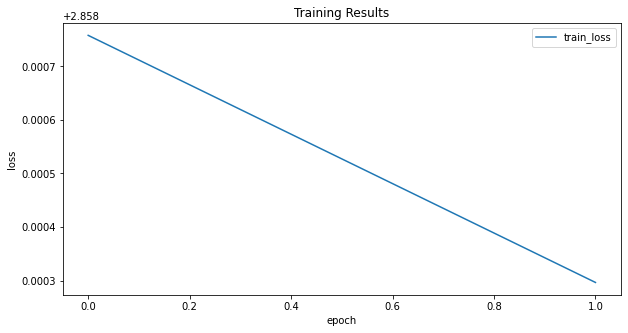

In [0]:
plot_loss(loss)

In [0]:
# torch.save(model_no_att, 'drive/My Drive/model_seq2seq_no_att.pkl')
model_no_att = torch.load('drive/My Drive/model_seq2seq_no_att.pkl')

In [0]:
def pred_dev(i, model):
    model.eval()

    text_sent = " ".join([inv_text_dict[word] for word in dev_text[i]])
    summ_truth = " ".join([inv_summ_dict[word] for word in dev_summ[i]]).strip('BOS').strip('EOS')
    print("text_sent is: ", text_sent)
    print("summ_truth is: ", summ_truth)

    sent = nltk.word_tokenize(text_sent.lower())
    bos = torch.Tensor([[summ_dict["BOS"]]]).long().to(device)
    
    mb_x = torch.Tensor([[text_dict.get(w, 0) for w in sent]]).long().to(device)
    mb_x_len = torch.Tensor([len(sent)]).long().to(device)
    
    summs, attention = model.predict(mb_x, mb_x_len, bos)
    summs = [inv_summ_dict[i] for i in summs.data.cpu().numpy().reshape(-1)]

    summ = []
    for word in summs:
        if word != "EOS":
            summ.append(word)
        else:
            break

    summ_pred = " ".join(summ)
    print("summ_pred is: ", summ_pred)
   

In [0]:
for i in range(1000,1003):
    pred_dev(i, model_no_att)
    print()

text_sent is:  BOS gave this as a gift to a french friend . she felt it was not like the mg 's she was used to in france . something about the `` glace '' part . the sugary cover was not right . i had one , and it was quite sticky . wonder if the quality is affected by UNK conditions . EOS
summ_truth is:   UNK UNK 
summ_pred is:  a little bit of my first

text_sent is:  BOS they 're all individually wrapped which is super convenient , the only thing is that when you first put them in your mouth , you almost ca n't handle the bitter taste , but a few seconds later you 'll start to taste matcha and green tea flavor . overall , it tastes really good if you like matcha taste . EOS
summ_truth is:   bitter at first then tastes really good 
summ_pred is:  matcha

text_sent is:  BOS i was looking for a canned bread with flavor for long-term storage . this product fills that need . i wish it was a little less pricey . the flavor is good . the biggest challange was getting it out of the can ! i 

In [0]:
!pip install rouge

In [0]:
from rouge import Rouge 

def rouge(i, model):
    model.eval()

    text_sent = " ".join([inv_text_dict[word] for word in dev_text[i]])
    summ_truth = " ".join([inv_summ_dict[word] for word in dev_summ[i]]).strip('BOS').strip('EOS')
    #print("text_sent is: ", text_sent)
    #print("summ_truth is: ", summ_truth)

    sent = nltk.word_tokenize(text_sent.lower())
    bos = torch.Tensor([[summ_dict["BOS"]]]).long().to(device)
    
    mb_x = torch.Tensor([[text_dict.get(w, 0) for w in sent]]).long().to(device)
    mb_x_len = torch.Tensor([len(sent)]).long().to(device)
    
    summs, attention = model.predict(mb_x, mb_x_len, bos)
    summs = [inv_summ_dict[i] for i in summs.data.cpu().numpy().reshape(-1)]

    summ = []
    for word in summs:
        if word != "EOS":
            summ.append(word)
        else:
            break
    #print(" ".join(trans))
    summ_pred = " ".join(summ)

    rouge = Rouge()
    scores = rouge.get_scores(summ_pred, summ_truth)

    return scores


In [0]:
rouge_1_f, rouge_1_p, rouge_1_r = [],[],[]
rouge_l_f, rouge_l_p, rouge_l_r = [],[],[]

for i in range(0, len(dev_text), 10):
    scores = rouge(i, model_no_att)

    rouge_1_f.append(scores[0]['rouge-1']['f'])
    rouge_1_p.append(scores[0]['rouge-1']['p'])
    rouge_1_r.append(scores[0]['rouge-1']['r'])

    rouge_l_f.append(scores[0]['rouge-l']['f'])
    rouge_l_p.append(scores[0]['rouge-l']['p'])
    rouge_l_r.append(scores[0]['rouge-l']['r'])

In [0]:
print('ROUGE-1 F1 is: ', np.mean(rouge_1_f))
print('ROUGE-1 precision is: ', np.mean(rouge_1_p))
print('ROUGE-1 recall is: ', np.mean(rouge_1_r))

print('ROUGE-l F1 is: ', np.mean(rouge_l_f))
print('ROUGE-l precision is: ', np.mean(rouge_l_p))
print('ROUGE-l recall is: ', np.mean(rouge_l_r))

ROUGE-1 F1 is:  0.0947512970252381
ROUGE-1 precision is:  0.11234936733913191
ROUGE-1 recall is:  0.09722388615458638
ROUGE-l F1 is:  0.09672409185757067
ROUGE-l precision is:  0.11393018871268616
ROUGE-l recall is:  0.09909729588021082


## Seq2seq with attention by dictionary word2vec

In [0]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, enc_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()
        
        hid = torch.cat([hid[-2], hid[-1]], dim=1)
        hid = torch.tanh(self.fc(hid)).unsqueeze(0)

        return out, hid


class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super(Attention, self).__init__()
        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size
        self.linear_in = nn.Linear(enc_hidden_size*2, dec_hidden_size, bias=False)
        self.linear_out = nn.Linear(enc_hidden_size*2 + dec_hidden_size, dec_hidden_size)
        
    def forward(self, output, context, mask):
        # output: batch_size, output_len, dec_hidden_size
        # context: batch_size, context_len, enc_hidden_size
        batch_size = output.size(0)
        output_len = output.size(1)
        input_len = context.size(1)
        
        context_in = self.linear_in(context.view(batch_size*input_len, -1)).view(batch_size, input_len, -1) # batch_size, output_len, dec_hidden_size
        attn = torch.bmm(output, context_in.transpose(1,2)) # batch_size, output_len, context_len
  
        attn.data.masked_fill(mask, -1e6)

        attn = F.softmax(attn, dim=2) # batch_size, output_len, context_len

        context = torch.bmm(attn, context) # batch_size, output_len, enc_hidden_size
        
        output = torch.cat((context, output), dim=2) # batch_size, output_len, hidden_size*2
        
        output = output.view(batch_size*output_len, -1)
        output = torch.tanh(self.linear_out(output))
        output = output.view(batch_size, output_len, -1)
        return output, attn



class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.out = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, x_len, y_len):
        device = x_len.device
        max_x_len = x_len.max()
        max_y_len = y_len.max()
        x_mask = torch.arange(max_x_len, device=x_len.device)[None, :] < x_len[:, None]
        y_mask = torch.arange(max_y_len, device=x_len.device)[None, :] < y_len[:, None]
        mask = (~x_mask[:, :, None] * y_mask[:, None, :]).byte()
        return mask
        
        
    def forward(self, ctx, ctx_lengths, y, y_lengths, hid):
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()]
        
        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, output_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()

        mask = self.create_mask(y_lengths, ctx_lengths)

        # code.interact(local=locals())
        output, attn = self.attention(output_seq, ctx, mask)
        output = F.log_softmax(self.out(output), -1)
        
        return output, hid, attn

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        return output, attn
    
    def predict(self, x, x_lengths, y, max_length=100):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            attns.append(attn)
        return torch.cat(preds, 1), torch.cat(attns, 1)

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_vocab_size = len(text_dict)
summ_vocab_size = len(summ_dict)
embed_size = hidden_size = 100
dropout = 0.1

encoder = Encoder(vocab_size=text_vocab_size, 
                  embed_size=embed_size, 
                  enc_hidden_size=hidden_size,
                  dec_hidden_size=hidden_size,
                  dropout=dropout)
decoder = Decoder(vocab_size=summ_vocab_size, 
                  embed_size=embed_size, 
                  enc_hidden_size=hidden_size,
                  dec_hidden_size=hidden_size,
                  dropout=dropout)
model_att = Seq2Seq(encoder, decoder)
model_att = model_att.to(device)
crit = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model_att.parameters(), lr=0.001)

In [0]:
loss = train(model_att, train_data, num_epochs=30)

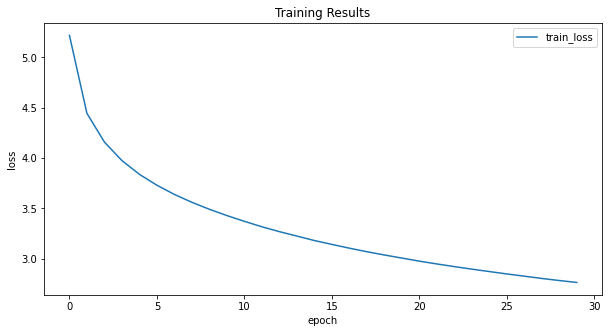

In [0]:
plot_loss(loss)

In [0]:
#torch.save(model_att, 'drive/My Drive/model_seq2seq_with_att.pkl')

model_att = torch.load('drive/My Drive/model_seq2seq_with_att.pkl')

In [0]:
for i in range(1000,1003):
    pred_dev(i, model_att)
    print()

In [0]:
rouge_1_f, rouge_1_p, rouge_1_r = [],[],[]
rouge_l_f, rouge_l_p, rouge_l_r = [],[],[]

for i in range(0, len(dev_text), 10):
    scores = rouge(i, model_att)

    rouge_1_f.append(scores[0]['rouge-1']['f'])
    rouge_1_p.append(scores[0]['rouge-1']['p'])
    rouge_1_r.append(scores[0]['rouge-1']['r'])

    rouge_l_f.append(scores[0]['rouge-l']['f'])
    rouge_l_p.append(scores[0]['rouge-l']['p'])
    rouge_l_r.append(scores[0]['rouge-l']['r'])
    

print('ROUGE-1 F1 is: ', np.mean(rouge_1_f))
print('ROUGE-1 precision is: ', np.mean(rouge_1_p))
print('ROUGE-1 recall is: ', np.mean(rouge_1_r))

print('ROUGE-l F1 is: ', np.mean(rouge_l_f))
print('ROUGE-l precision is: ', np.mean(rouge_l_p))
print('ROUGE-l recall is: ', np.mean(rouge_l_r))

ROUGE-1 F1 is:  0.11928154826957028
ROUGE-1 precision is:  0.1434966952188037
ROUGE-1 recall is:  0.11914756876976156
ROUGE-l F1 is:  0.12215514537329088
ROUGE-l precision is:  0.146572631564955
ROUGE-l recall is:  0.1207956605586616


## Seq2seq with attention by pre-trained wiki word embeddings

In [0]:
import os
import sys
import math
from collections import Counter
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
embed_raw = pickle.load(open("drive/My Drive/cc.en.300.pkl", "rb"))

In [0]:
embed_dim = len(embed_raw['Band'])

print(len(embed_raw), embed_dim)

2000000 300


In [0]:
DATA_PATH = 'drive/My Drive/'
reviews = pd.read_csv(f'{DATA_PATH}Reviews.csv', usecols=['Summary', 'Text'], engine='python', encoding='utf-8', error_bad_lines=False)

# drop rows with no Summary
reviews.dropna(inplace=True)

# drop duplicated 
reviews.drop_duplicates(['Text'], keep='first', inplace=True)
print('total reviews', reviews.shape[0])
reviews.head(5)

total reviews 393576


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


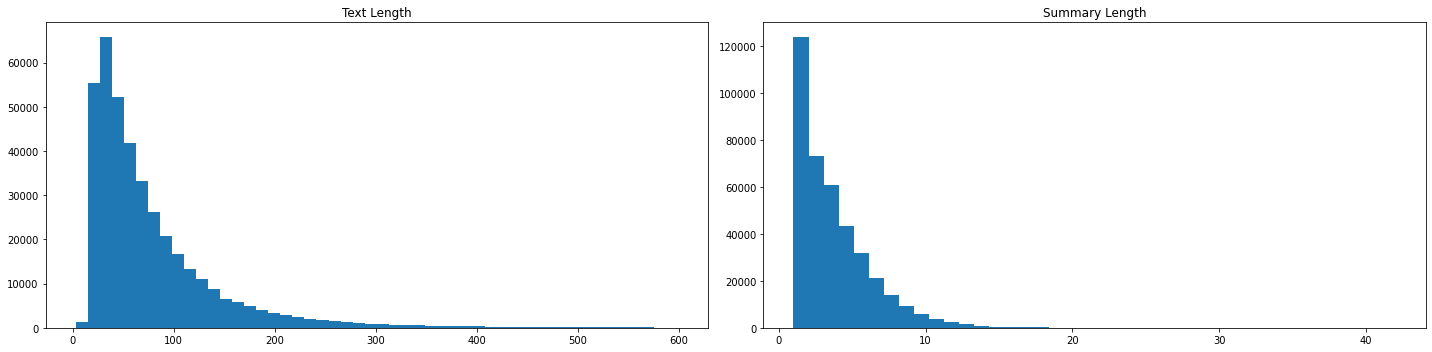

In [0]:
reviews['Summary_len'] = reviews.Summary.apply(lambda x: len(x.split()))
reviews['Text_len'] = reviews.Text.apply(lambda x: len(x.split()))  

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.hist(reviews.Text_len[reviews['Text_len'] < 600], bins=50)
plt.title('Text Length')

plt.subplot(1, 2, 2)
plt.hist(reviews['Summary_len'], bins=40)
plt.title('Summary Length')
plt.tight_layout()

In [0]:
# drop short reviews < 10
reviews = reviews[(reviews['Text_len'] > 50) & (reviews['Text_len'] < 200)].reset_index(drop=True)

print('total reviews', reviews.shape[0])

total reviews 195348


In [0]:
train_df, test_df = train_test_split(reviews, test_size=0.1, random_state=100)

In [0]:
def load_data(df):
    text = []
    summ = []
    num_examples = 0

    for line in df.Text.values:
          line = line.strip().split("\t")
          text.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])

    for line in df.Summary.values:
          line = line.strip().split("\t")
          summ.append(["BOS"] + nltk.word_tokenize(line[0].lower()) + ["EOS"])
    
    return text, summ


train_text, train_summ = load_data(train_df)
dev_text, dev_summ = load_data(test_df)

In [0]:
print('Text example: ', train_text[2])
print('Summary example: ', train_summ[2])

Text example:  ['BOS', 'these', 'chips', 'are', 'unusual', 'and', 'they', 'do', '``', 'grow', "''", 'on', 'you', '.', 'the', 'taste', 'is', 'most', 'like', 'shoestring', 'potatoes', ',', 'of', 'which', 'i', 'am', 'boderline', 'addicted', '.', 'i', 'would', 'order', 'these', 'again', ',', 'but', 'they', 'are', 'just', 'too', 'salty', 'for', 'my', 'taste', '.', 'i', 'ordered', 'the', 'plain', ',', 'so', 'i', 'do', "n't", 'know', 'if', 'the', 'other', 'flavors', 'are', 'also', 'salty', '.', 'EOS']
Summary example:  ['BOS', 'good', 'taste', ',', 'a', 'little', 'too', 'salty', 'EOS']


In [0]:
UNK_IDX = 0
PAD_IDX = 1

def build_dict(sentences, max_words=50000):
    word_count = Counter()
    for sentence in sentences:
        for s in sentence:
            word_count[s] += 1
    ls = word_count.most_common(max_words)
    total_words = len(ls) + 2
    word_dict = {w[0]: index+2 for index, w in enumerate(ls)}
    word_dict["UNK"] = UNK_IDX
    word_dict["PAD"] = PAD_IDX
    return word_dict, total_words

text_dict, text_total_words = build_dict(train_text)
summ_dict, summ_total_words = build_dict(train_summ)
inv_text_dict = {v: k for k, v in text_dict.items()}
inv_summ_dict = {v: k for k, v in summ_dict.items()}

In [0]:
inv_text_dict[19]

'BOS'

In [0]:
def embedding(text_sentences, summ_sentences, text_dict, summ_dict, sort_by_len=True):
    '''
    Enmbedding the sentence to vector sequences.  
    '''
    length = len(text_sentences)
    out_text_sentences = [[text_dict.get(w, 0) for w in sent] for sent in text_sentences]
    out_summ_sentences = [[summ_dict.get(w, 0) for w in sent] for sent in summ_sentences]

    # sort sentences by english lengths
    def len_argsort(seq):
        return sorted(range(len(seq)), key=lambda x: len(seq[x]))
       
    if sort_by_len:
        sorted_index = len_argsort(out_text_sentences)
        out_text_sentences = [out_text_sentences[i] for i in sorted_index]
        out_summ_sentences = [out_summ_sentences[i] for i in sorted_index]
        
    return out_text_sentences, out_summ_sentences

train_text, train_summ = embedding(train_text, train_summ, text_dict, summ_dict)
dev_text, dev_summ = embedding(dev_text, dev_summ, text_dict, summ_dict)

In [0]:
def get_minibatches(n, minibatch_size, shuffle=True):
    idx_list = np.arange(0, n, minibatch_size)
    if shuffle:
        np.random.shuffle(idx_list)
    minibatches = []
    for idx in idx_list:
        minibatches.append(np.arange(idx, min(idx + minibatch_size, n)))
    return minibatches

def prepare_data(seqs):
    lengths = [len(seq) for seq in seqs]
    n_samples = len(seqs)
    max_len = np.max(lengths)

    x = np.zeros((n_samples, max_len)).astype('int32')
    x_lengths = np.array(lengths).astype("int32")
    for idx, seq in enumerate(seqs):
        x[idx, :lengths[idx]] = seq
    return x, x_lengths #x_mask

def gen_examples(text_sentences, summ_sentences, batch_size):
    minibatches = get_minibatches(len(text_sentences), batch_size)
    all_ex = []
    for minibatch in minibatches:
        mb_text_sentences = [text_sentences[t] for t in minibatch]
        mb_summ_sentences = [summ_sentences[t] for t in minibatch]
        mb_x, mb_x_len = prepare_data(mb_text_sentences)
        mb_y, mb_y_len = prepare_data(mb_summ_sentences)
        all_ex.append((mb_x, mb_x_len, mb_y, mb_y_len))
    return all_ex

batch_size = 64
train_data = gen_examples(train_text, train_summ, batch_size)
random.shuffle(train_data)
dev_data = gen_examples(dev_text, dev_summ, batch_size)

In [0]:
np.shape(train_data)

(2748, 4)

In [0]:
def create_embeddings(vect, idx2word, emb_size, pad_idx=1):
    emb = nn.Embedding(len(idx2word), emb_size, padding_idx=pad_idx)
    weights = emb.weight.data
    for i, word in enumerate(idx2word):
        try:
            weights[i] = torch.from_numpy(vect[word] * 3)
        except:
            pass

    emb.weight.requires_grad = False
    return emb

def rand_t(*sz): 
    return torch.randn(sz) / np.sqrt(sz[0])

def rand_p(*sz): 
    return nn.Parameter(rand_t(*sz))

In [0]:
class Encoder(nn.Module):
    def __init__(self, vecs_enc, idx2word_enc, em_sz_enc, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Encoder, self).__init__()
        self.embed = create_embeddings(vecs_enc, idx2word_enc, em_sz_enc, pad_idx=1)  # nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, enc_hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(enc_hidden_size * 2, dec_hidden_size)

    def forward(self, x, lengths):
        sorted_len, sorted_idx = lengths.sort(0, descending=True)
        x_sorted = x[sorted_idx.long()]
        embedded = self.dropout(self.embed(x_sorted))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, sorted_len.long().cpu().data.numpy(), batch_first=True)
        packed_out, hid = self.rnn(packed_embedded)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        out = out[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()
        
        hid = torch.cat([hid[-2], hid[-1]], dim=1)
        hid = torch.tanh(self.fc(hid)).unsqueeze(0)

        return out, hid


class Attention(nn.Module):
    def __init__(self, enc_hidden_size, dec_hidden_size):
        super(Attention, self).__init__()

        self.enc_hidden_size = enc_hidden_size
        self.dec_hidden_size = dec_hidden_size

        self.linear_in = nn.Linear(enc_hidden_size*2, dec_hidden_size, bias=False)
        self.linear_out = nn.Linear(enc_hidden_size*2 + dec_hidden_size, dec_hidden_size)
        
    def forward(self, output, context, mask):
        # output: batch_size, output_len, dec_hidden_size
        # context: batch_size, context_len, enc_hidden_size
    
        batch_size = output.size(0)
        output_len = output.size(1)
        input_len = context.size(1)
        
        context_in = self.linear_in(context.view(batch_size*input_len, -1)).view(batch_size, input_len, -1) # batch_size, output_len, dec_hidden_size
        attn = torch.bmm(output, context_in.transpose(1,2)) # batch_size, output_len, context_len
        
        attn.data.masked_fill(mask, -1e6)

        attn = F.softmax(attn, dim=2) # batch_size, output_len, context_len

        context = torch.bmm(attn, context) # batch_size, output_len, enc_hidden_size
        
        output = torch.cat((context, output), dim=2) # batch_size, output_len, hidden_size*2

        output = output.view(batch_size*output_len, -1)
        output = torch.tanh(self.linear_out(output))
        output = output.view(batch_size, output_len, -1)
        return output, attn


class Decoder(nn.Module):
    def __init__(self, vecs_dec, idx2word_dec, em_sz_dec, vocab_size, embed_size, enc_hidden_size, dec_hidden_size, dropout=0.2):
        super(Decoder, self).__init__()
        self.embed = create_embeddings(vecs_dec, idx2word_dec, em_sz_dec, pad_idx=1)  #nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(enc_hidden_size, dec_hidden_size)
        self.rnn = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.out = nn.Linear(dec_hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_mask(self, x_len, y_len):
        device = x_len.device
        max_x_len = x_len.max()
        max_y_len = y_len.max()
        x_mask = torch.arange(max_x_len, device=x_len.device)[None, :] < x_len[:, None]
        y_mask = torch.arange(max_y_len, device=x_len.device)[None, :] < y_len[:, None]
        mask = (~x_mask[:, :, None] * y_mask[:, None, :]).byte()
        return mask
        
        
    def forward(self, ctx, ctx_lengths, y, y_lengths, hid):
        sorted_len, sorted_idx = y_lengths.sort(0, descending=True)
        y_sorted = y[sorted_idx.long()]
        hid = hid[:, sorted_idx.long()]
        
        y_sorted = self.dropout(self.embed(y_sorted)) # batch_size, output_length, embed_size

        packed_seq = nn.utils.rnn.pack_padded_sequence(y_sorted, sorted_len.long().cpu().data.numpy(), batch_first=True)
        out, hid = self.rnn(packed_seq, hid)
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        _, original_idx = sorted_idx.sort(0, descending=False)
        output_seq = unpacked[original_idx.long()].contiguous()
        hid = hid[:, original_idx.long()].contiguous()

        mask = self.create_mask(y_lengths, ctx_lengths)

        # code.interact(local=locals())
        output, attn = self.attention(output_seq, ctx, mask)
        output = F.log_softmax(self.out(output), -1)
        
        return output, hid, attn

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, x_lengths, y, y_lengths):
        encoder_out, hid = self.encoder(x, x_lengths)
        output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=y_lengths,
                    hid=hid)
        return output, attn
    
    def predict(self, x, x_lengths, y, max_length=100):
        encoder_out, hid = self.encoder(x, x_lengths)
        preds = []
        batch_size = x.shape[0]
        attns = []
        for i in range(max_length):
            output, hid, attn = self.decoder(ctx=encoder_out, 
                    ctx_lengths=x_lengths,
                    y=y,
                    y_lengths=torch.ones(batch_size).long().to(y.device),
                    hid=hid)
            y = output.max(2)[1].view(batch_size, 1)
            preds.append(y)
            attns.append(attn)
        return torch.cat(preds, 1), torch.cat(attns, 1)

In [0]:
class LanguageModelCriterion(nn.Module):
    def __init__(self):
        super(LanguageModelCriterion, self).__init__()

    def forward(self, input, target, mask):
        input = input.contiguous().view(-1, input.size(2))
        target = target.contiguous().view(-1, 1)
        mask = mask.contiguous().view(-1, 1)
        output = -input.gather(1, target) * mask
        output = torch.sum(output) / torch.sum(mask)

        return output

In [0]:
def evaluate(model, data):
    model.eval()
    total_num_words = total_loss = 0.
    with torch.no_grad():
        for it, (mb_x, mb_x_lengths, mb_y, mb_y_lengths) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).long().to(device)
            mb_x_lengths = torch.from_numpy(mb_x_lengths).long().to(device)
            mb_input = torch.from_numpy(mb_y[:,:-1]).long().to(device)
            mb_out = torch.from_numpy(mb_y[:, 1:]).long().to(device)
            mb_y_lengths = torch.from_numpy(mb_y_lengths-1).long().to(device)
            mb_y_lengths[mb_y_lengths <= 0] = 1

            mb_pred, attn = model(mb_x, mb_x_lengths, mb_input, mb_y_lengths)

            mb_out_mask = torch.arange(mb_y_lengths.max().item(), device=device)[None, :] < mb_y_lengths[:, None]
            mb_out_mask = mb_out_mask.float()
            loss = crit(mb_pred, mb_out, mb_out_mask)

            num_words = torch.sum(mb_y_lengths).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words

    print("evaluation loss", total_loss/total_num_words)

In [0]:
def train(model, data, num_epochs):
    ls = []
    for epoch in range(num_epochs):
        total_num_words = total_loss = 0.
        model.train()
        for it, (mb_x, mb_x_lengths, mb_y, mb_y_lengths) in enumerate(data):
            mb_x = torch.from_numpy(mb_x).long().to(device)
            mb_x_lengths = torch.from_numpy(mb_x_lengths).long().to(device)
            mb_input = torch.from_numpy(mb_y[:,:-1]).long().to(device)
            mb_out = torch.from_numpy(mb_y[:, 1:]).long().to(device)
            mb_y_lengths = torch.from_numpy(mb_y_lengths-1).long().to(device)
            mb_y_lengths[mb_y_lengths <= 0] = 1

            mb_pred, attn = model(mb_x, mb_x_lengths, mb_input, mb_y_lengths)

            mb_out_mask = torch.arange(mb_y_lengths.max().item(), device=device)[None, :] < mb_y_lengths[:, None]
            mb_out_mask = mb_out_mask.float()
            loss = crit(mb_pred, mb_out, mb_out_mask)

            num_words = torch.sum(mb_y_lengths).item()
            total_loss += loss.item() * num_words
            total_num_words += num_words

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.)
            optimizer.step()

            if it % 100 == 0:
                print("epoch", epoch, "iteration", it, "loss", loss.item())
        print("epoch", epoch, "training loss", total_loss/total_num_words)
        if epoch % 5 == 0:
            print("evaluating on dev...")
            evaluate(model, dev_data)

        ls.append(total_loss/total_num_words)

    return ls    

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

text_vocab_size = len(text_dict)
summ_vocab_size = len(summ_dict)
embed_size =  embed_dim
hidden_size = 100
dropout = 0.1

encoder = Encoder(vecs_enc=embed_raw, idx2word_enc=inv_text_dict, em_sz_enc=embed_dim, 
                  vocab_size=text_vocab_size, 
                  embed_size=embed_size, 
                  enc_hidden_size=hidden_size,
                  dec_hidden_size=hidden_size,
                  dropout=dropout)

decoder = Decoder(vecs_dec=embed_raw, idx2word_dec=inv_summ_dict, em_sz_dec=embed_dim,
                  vocab_size=summ_vocab_size, 
                  embed_size=embed_size, 
                  enc_hidden_size=hidden_size,
                  dec_hidden_size=hidden_size,
                  dropout=dropout)

model_emb = Seq2Seq(encoder, decoder)
model_emb = model_emb.to(device)
crit = LanguageModelCriterion().to(device)
optimizer = torch.optim.Adam(model_emb.parameters(), lr=0.001)

In [0]:
loss = train(model_emb, train_data, num_epochs=30)

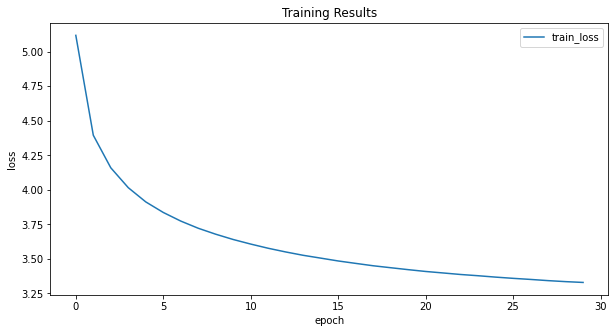

In [103]:
def plot_loss(loss):
    plt.figure(figsize=(10, 5))
    plt.plot(loss, label='train_loss')
    plt.legend()
    plt.title('Training Results')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


plot_loss(loss)

In [104]:
torch.save(model_emb, 'drive/My Drive/model_seq2seq_emb.pkl')

#model_emb = torch.load('drive/My Drive/model_seq2seq_emb.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Seq2Seq. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Attention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
def pred_dev(i, model):
    model.eval()

    text_sent = " ".join([inv_text_dict[word] for word in dev_text[i]])
    summ_truth = " ".join([inv_summ_dict[word] for word in dev_summ[i]]).strip('BOS').strip('EOS')
    print("text_sent is: ", text_sent)
    print("summ_truth is: ", summ_truth)

    sent = nltk.word_tokenize(text_sent.lower())
    bos = torch.Tensor([[summ_dict["BOS"]]]).long().to(device)
    
    mb_x = torch.Tensor([[text_dict.get(w, 0) for w in sent]]).long().to(device)
    mb_x_len = torch.Tensor([len(sent)]).long().to(device)
    
    summs, attention = model.predict(mb_x, mb_x_len, bos)
    summs = [inv_summ_dict[i] for i in summs.data.cpu().numpy().reshape(-1)]

    summ = []
    for word in summs:
        if word != "EOS":
            summ.append(word)
        else:
            break

    summ_pred = " ".join(summ)
    print("summ_pred is: ", summ_pred)

    return text_sent, summ_truth, summ_pred


In [0]:
for num in range(0, len(dev_text), 200):
    text_sent, summ_truth, summ_pred_emb = pred_dev(num, model_emb)
    print('*' * 50)

In [107]:
!pip install rouge

In [0]:
from rouge import Rouge 

def rouge(i, model):
    model.eval()

    text_sent = " ".join([inv_text_dict[word] for word in dev_text[i]])
    summ_truth = " ".join([inv_summ_dict[word] for word in dev_summ[i]]).strip('BOS').strip('EOS')
    #print("text_sent is: ", text_sent)
    #print("summ_truth is: ", summ_truth)

    sent = nltk.word_tokenize(text_sent.lower())
    bos = torch.Tensor([[summ_dict["BOS"]]]).long().to(device)
    
    mb_x = torch.Tensor([[text_dict.get(w, 0) for w in sent]]).long().to(device)
    mb_x_len = torch.Tensor([len(sent)]).long().to(device)
    
    summs, attention = model.predict(mb_x, mb_x_len, bos)
    summs = [inv_summ_dict[i] for i in summs.data.cpu().numpy().reshape(-1)]

    summ = []
    for word in summs:
        if word != "EOS":
            summ.append(word)
        else:
            break
    #print(" ".join(trans))
    summ_pred = " ".join(summ)

    rouge = Rouge()
    scores = rouge.get_scores(summ_pred, summ_truth)

    return scores

In [0]:
rouge_1_f, rouge_1_p, rouge_1_r = [],[],[]
rouge_l_f, rouge_l_p, rouge_l_r = [],[],[]

for i in range(0, len(dev_text), 10):

    scores = rouge(i, model_emb)

    rouge_1_f.append(scores[0]['rouge-1']['f'])
    rouge_1_p.append(scores[0]['rouge-1']['p'])
    rouge_1_r.append(scores[0]['rouge-1']['r'])

    rouge_l_f.append(scores[0]['rouge-l']['f'])
    rouge_l_p.append(scores[0]['rouge-l']['p'])
    rouge_l_r.append(scores[0]['rouge-l']['r'])


In [110]:
print('ROUGE-1 F1 is: ', np.mean(rouge_1_f))
print('ROUGE-1 precision is: ', np.mean(rouge_1_p))
print('ROUGE-1 recall is: ', np.mean(rouge_1_r))

print('ROUGE-l F1 is: ', np.mean(rouge_l_f))
print('ROUGE-l precision is: ', np.mean(rouge_l_p))
print('ROUGE-l recall is: ', np.mean(rouge_l_r))

ROUGE-1 F1 is:  0.12466284106695578
ROUGE-1 precision is:  0.1508298814798303
ROUGE-1 recall is:  0.12995765435820525
ROUGE-l F1 is:  0.1304735394746524
ROUGE-l precision is:  0.156153168166986
ROUGE-l recall is:  0.13080966565966773


### Result comparison

In [0]:
def res():
  res = pd.DataFrame(columns=['idx', 'text_sent', 'summ_truth', 'summ_pred_no_att', 'summ_pred_with_att', 'summ_pred_emb'])

  for num in range(0, len(dev_text), 200):
    text_sent, summ_truth, summ_pred_no_att = pred_dev(num, model_no_att)
    text_sent, summ_truth, summ_pred_with_att = pred_dev(num, model_with_att)
    text_sent, summ_truth, summ_pred_emb = pred_dev(num, model_emb)

    res = res.append([{'idx':num, 'text_sent':text_sent, 'summ_truth':summ_truth, 'summ_pred_no_att':summ_pred_no_att, 'summ_pred_with_att':summ_pred_with_att, 'summ_pred_emb':summ_pred_emb}])

  return res


model_no_att = torch.load('drive/My Drive/model_seq2seq_no_att.pkl')
model_with_att = torch.load('drive/My Drive/model_seq2seq_with_att.pkl')
model_emb = torch.load('drive/My Drive/model_seq2seq_emb.pkl')

res_com = res()

In [0]:
res_com.to_csv("drive/My Drive/res_comparison.csv")